# Test Parallel Processing

This script is used to test whether the parallel processing works in [the docker image](https://hub.docker.com/r/hcp4715/hddm). It includes two parts:
* Part 1: test parallel processing using easy calculations
* Part 2: test parallel processing using HDDM's modelling

**Please make sure that you started multiple engines at the IPython Cluster**


**Note**: Example data are from [Hu et al. (2020)'s Experiment 2](https://collabra.org/articles/10.1525/collabra.301/). This data can be downloaded from [github](https://github.com/hcp4715/moralSelf_ddm/blob/master/2_confirm_study/Results/3_hddm/MS_match_hddm_stim.csv) too.

In [1]:
# check which python is in use.
import sys
print('Notebook is running:', sys.executable) # /opt/conda/bin/python

# or uncomment the code below
from platform import python_version # 3.7.6

print('The current Python version is', python_version())

import hddm, IPython
print('The current HDDM version is', hddm.__version__) # 0.8.0

import kabuki
print('The current kabuki version is', kabuki.__version__) # 0.6.3

import matplotlib
print('The current matplotlib version is', matplotlib.__version__) # 0.3.1.3

# Warning:`IPython.parallel` package has been deprecated since IPython 4.0. 
#print('The current IPython version is', IPython.__version__) 

import os
cur_dir = os.getcwd()
print('The current working directory is', cur_dir)


import warnings
#### Note: the code below will suppress all warnings, if you want to be alerted by the warning, please comment it
warnings.filterwarnings('ignore')

Notebook is running: /opt/conda/bin/python
The current Python version is 3.7.6
The current HDDM version is 0.8.0
The current kabuki version is 0.6.3
The current matplotlib version is 3.2.2
The current working directory is /home/jovyan/example


/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Part 1: testing ipyparallel

Test computing using examples from this [tutorial](http://people.duke.edu/~ccc14/sta-663-2016/19C_IPyParallel.html).

** There should no error for the code below **

In [2]:
import ipyparallel as ipp
rc = ipp.Client()
rc.ids

[0, 1, 2, 3, 4]

In [3]:
def foo():
    import time
    time.sleep(5)
    return 'foo'

def bar():
    import time
    time.sleep(10) 
    return 'bar'  

res1 = rc[0].apply(foo)
res2 = rc[1].apply(bar)
results = [res1, res2]

while not all(map(lambda ar: ar.ready(), results)):
    pass

print(res1.get(), res2.get())

foo bar


In [4]:
dv = rc[:]

res = dv.map(lambda x, y, z: x + y + z, range(10), range(10), range(10))
res.get()

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

In [5]:
@dv.remote(block = True)
def f1(n):
    import numpy as np
    return np.random.rand(n)
f1(4)

[array([0.95110841, 0.77100166, 0.67667633, 0.21459368]),
 array([0.38742392, 0.49215118, 0.24372955, 0.88594729]),
 array([0.20611293, 0.08184162, 0.51759676, 0.27852188]),
 array([0.56095838, 0.99690429, 0.61413738, 0.78343868]),
 array([0.23334271, 0.60062345, 0.84950896, 0.32894744])]

## Part 2: Test parallel processing using HDDM's func

In [6]:
%matplotlib inline

# Preparation
import os, time, csv, datetime
import kabuki, hddm
from kabuki.analyze import gelman_rubin

from datetime import date

import random
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# check the data
# load data
df = hddm.load_csv('df_example.csv')
df.head(10)  # uncomment if you want to check the head of the data

,subj_idx,match,val,id,stim,response,rt
0,7304,mismatch,Bad,Other,0,1,0.7247
1,7304,mismatch,Bad,Self,0,0,0.8786
2,7304,match,Good,Other,1,1,0.8167
3,7304,match,Bad,Other,1,0,0.8728
4,7304,mismatch,Good,Other,0,1,0.6849
5,7304,mismatch,Bad,Self,0,1,0.6951
6,7304,match,Good,Self,1,1,0.4951
7,7304,match,Bad,Other,1,0,0.8713
8,7304,match,Good,Self,1,1,0.5954
9,7304,match,Bad,Other,1,1,0.6875


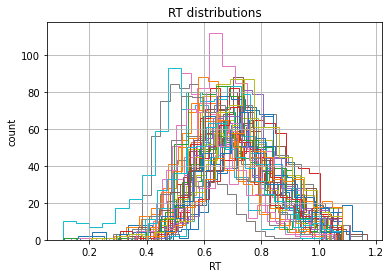

In [8]:
# Uncomment the codes below if you are interested in checking the distribution of raw data
# plot and save the distribution of raw data:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in df.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

In [9]:
# define a function to run model in parallel
def run_model(id):
    print('running model%i'%id);
    
    import hddm
    import random
    #import os
    
    #cur_dir = os.getcwd()

    exp_name = 'example'
    print('running models %i'%id, 'for for exp', exp_name)
    
    # USE the absolute directory in docker.
    dbname = '/home/jovyan/example/df_' + exp_name + '_chain_vaz_test_%i.db'%id # define the database name, which uses pickle format
    mname  = '/home/jovyan/example/df_' + exp_name + '_chain_vaz_test_%i'%id    # define the name for the model
    fname  = '/home/jovyan/example/df_' + exp_name + '.csv'
    df = hddm.load_csv(fname)

    df_subj = df['subj_idx'].unique()

    # random select without repetition
    random.seed(10)
    df_test_list = []
    for i in range(10):
        pos = random.randint(0, (len(df_subj)-1))
        df_test_list.append(df_subj[pos])  
    
    df_test = df[df['subj_idx'].isin(df_test_list)]
    
    m = hddm.HDDMStimCoding(df_test, 
                            include='z', 
                            stim_col='stim', 
                            depends_on={'v':['match','val', 'id']},
                            split_param='v', 
                            drift_criterion=False,
                            p_outlier=0.05)
    m.find_starting_values()
    m.sample(500, burn=100, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

### Test the docker image: Single chain

In [10]:
start_time = time.time()  # the start time of the processing

m = run_model(0)

print("\nRunning 1 chain used: %f seconds." % (time.time() - start_time))

running model0
running models 0 for for exp example
 [-----------------100%-----------------] 501 of 500 complete in 152.2 sec
Running 1 chain used: 164.060772 seconds.


In [11]:
# m = hddm.load("df_example_chain_vaz_test_0")
print("M_df1a_v_corr DIC: %f" % m.dic) 

M_df1a_v_corr DIC: 645.218330


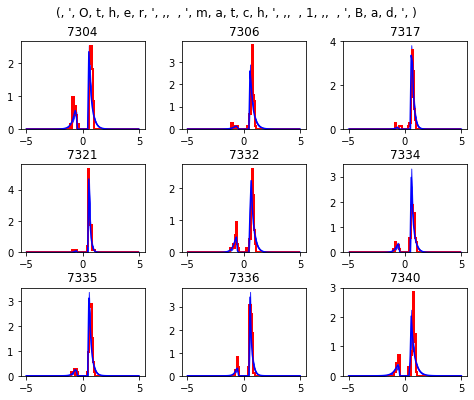

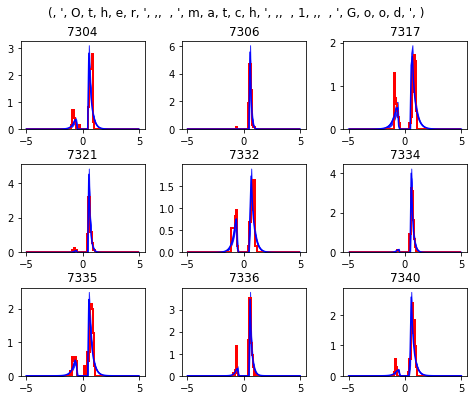

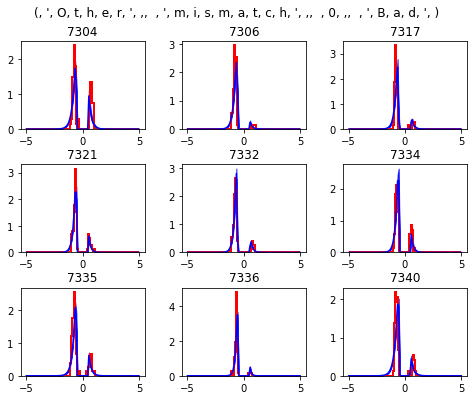

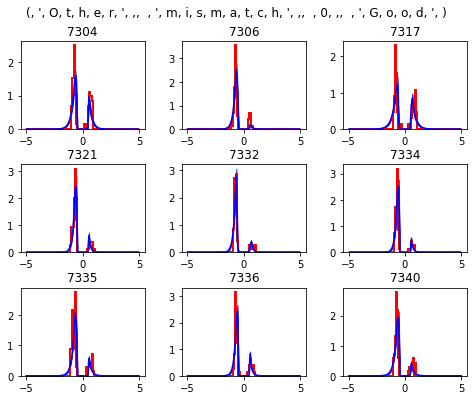

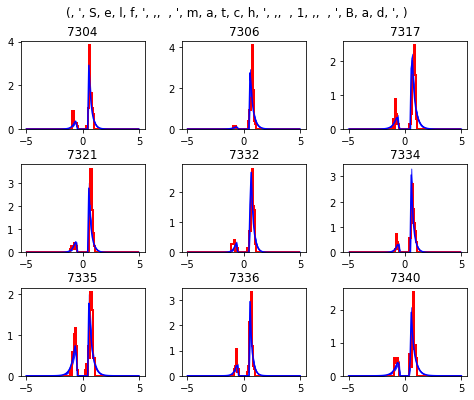

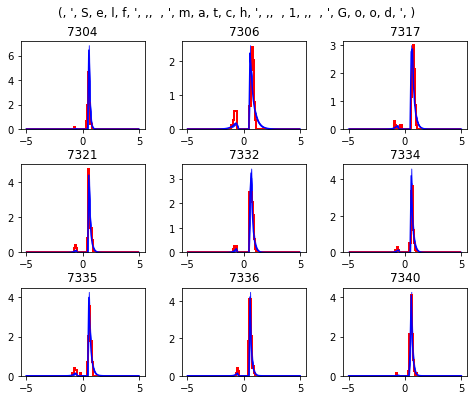

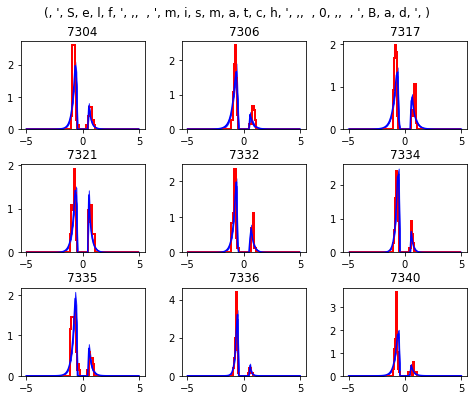

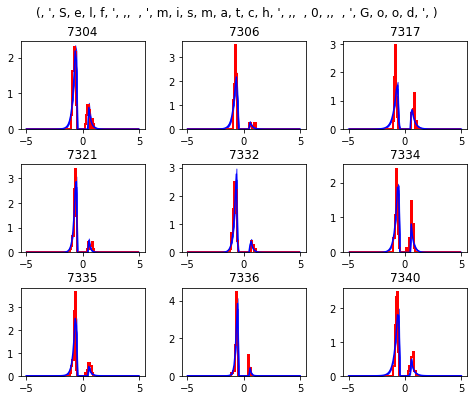

In [12]:
m.plot_posterior_predictive()

### Test the docker image: Multiple chains in parallel

In [13]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_model, range(4)) # 4 is the number of CPUs
models = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))


Running 4 chains used: 204.622342 seconds.


In [14]:
print("M_df1a_v_corr DIC: %f" % models[0].dic) 

gelman_rubin(models)

M_df1a_v_corr DIC: 650.885916


{'a': 1.0023530612089933,
 'a_std': 1.016338256000211,
 'a_subj.7304': 1.0021116359183442,
 'a_subj.7306': 1.0049318391932078,
 'a_subj.7317': 0.9992638453166611,
 'a_subj.7321': 0.9987873979786993,
 'a_subj.7332': 0.9997011357228868,
 'a_subj.7334': 1.0034041881001003,
 'a_subj.7335': 1.0010669756088937,
 'a_subj.7336': 1.0073508579906698,
 'a_subj.7340': 1.0005509986269872,
 'v(Other.match.Bad)': 1.0035231535697813,
 'v(Other.match.Good)': 0.999827524880175,
 'v(Other.mismatch.Bad)': 0.9992883183405373,
 'v(Other.mismatch.Good)': 1.005804597138293,
 'v(Self.match.Bad)': 0.9992305072197251,
 'v(Self.match.Good)': 1.0046873469647197,
 'v(Self.mismatch.Bad)': 0.9988007064341768,
 'v(Self.mismatch.Good)': 1.0000451374724304,
 'v_std': 1.0023188861536643,
 'v_subj(Other.match.Bad).7304': 1.0014159130329303,
 'v_subj(Other.match.Good).7304': 0.9993436877652554,
 'v_subj(Other.match.Bad).7306': 1.0014995226745347,
 'v_subj(Other.match.Good).7306': 0.9995237655220955,
 'v_subj(Other.match.Ba

In [15]:
# Create a new model concatenating all individual models.
import kabuki
combined_model = kabuki.utils.concat_models(models)

### Check convergence (visual inspection)

Here I defined a function to plot multiple chain and visually inspect the convergence. Note that in a hierarchical model, there are both group-level and individual-level parameters, here I only plot the group-level parameters. 

You can enter 'v', 'a', 't', 'z' as the params, now the function only takes one parameter.

In [16]:
def plot_grp_trace(models, param = 'v'):
    import seaborn as sns
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    df_grp_traces = []
    for i in range(4):
        df_m = models[i]
        df_grp_trace = df_m.get_group_traces()
        df_grp_trace['chain'] = i
        print('chain', i, df_grp_trace.shape)
        df_grp_traces.append(df_grp_trace)
    df_grp_traces = pd.concat(df_grp_traces)
    
    # select the columns included that parameter
    filter_col = [col for col in df_grp_traces if col.startswith(param)]
    filter_col.append('chain') # add the chain column to the data
    
    #df_tmp = df_grp_traces[df_grp_traces.columns.intersection(filter_col)]
    df_tmp = df_grp_traces.loc[:,filter_col]
    df_tmp["sample_id"] = df_tmp.index
    
    df_melt = pd.melt(df_tmp,
                      id_vars=['sample_id', 'chain'],
                      value_vars=filter_col[:-1],
                      var_name='cond',
                      value_name='value')
    
    sns.set_palette("Set2")
    for indx, df_tmp in df_melt.groupby('cond'):

        fig, axs = plt.subplots(ncols=2,figsize=(20, 9))
        print(indx)

        sns.lineplot(x='sample_id', y='value', hue="chain", data=df_tmp, ax=axs[0], palette='Set2')

        sns.distplot(df_tmp.loc[df_tmp['chain'] == 0, 'value'], hist = False, kde = True,
                         kde_kws = {'shade': False, 'linewidth': 3},ax=axs[1], label = '0')
        sns.distplot(df_tmp.loc[df_tmp['chain'] == 1, 'value'], hist = False, kde = True,
                         kde_kws = {'shade': False, 'linewidth': 3},ax=axs[1], label = '1')
        sns.distplot(df_tmp.loc[df_tmp['chain'] == 2, 'value'], hist = False, kde = True,
                         kde_kws = {'shade': False, 'linewidth': 3},ax=axs[1], label = '2')
        sns.distplot(df_tmp.loc[df_tmp['chain'] == 3, 'value'], hist = False, kde = True,
                         kde_kws = {'shade': False, 'linewidth': 3},ax=axs[1], label = '3')

        #axs[0].set_ylim([0.5, 3])
        axs[0].set_title(indx, fontsize=20)
        #axs[1].set_xlim([0.5, 3])
        axs[1].set_title(indx, fontsize=20)
        plt.show()

chain 0 (400, 16)
chain 1 (400, 16)
chain 2 (400, 16)
chain 3 (400, 16)
v(Other.match.Bad)


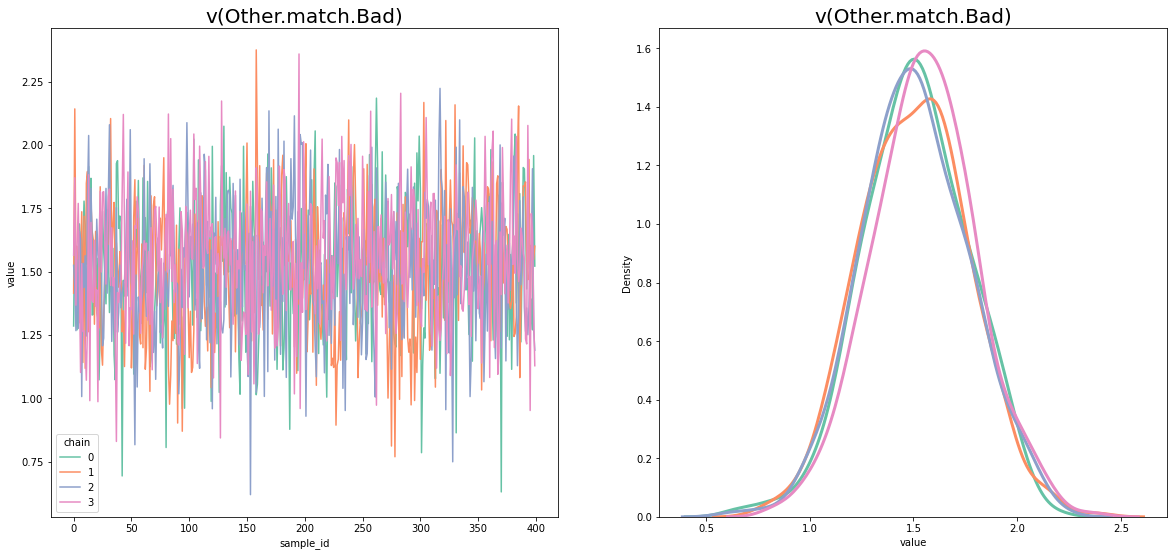

v(Other.match.Good)


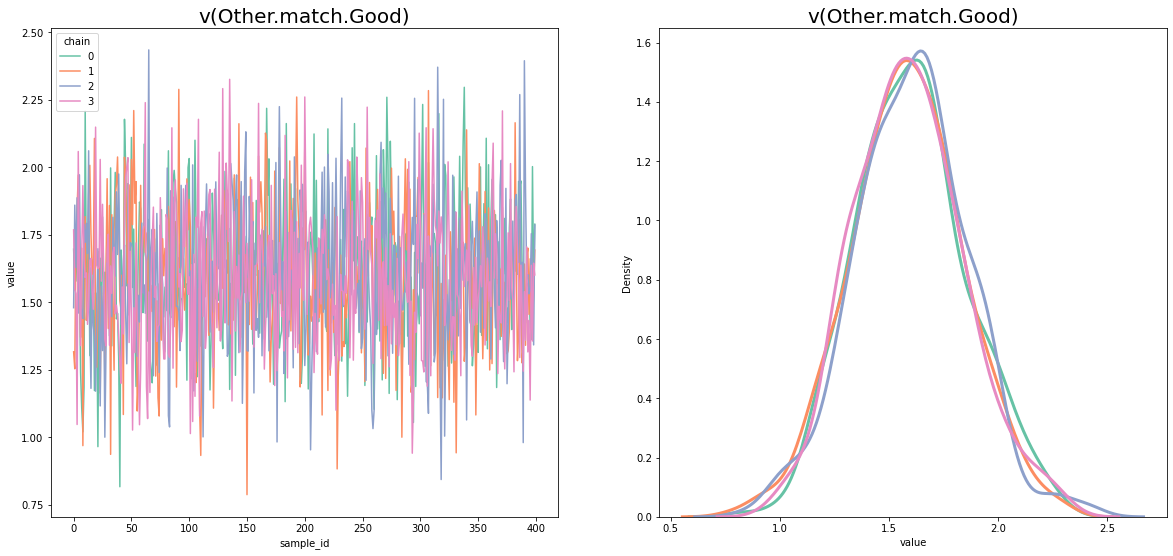

v(Other.mismatch.Bad)


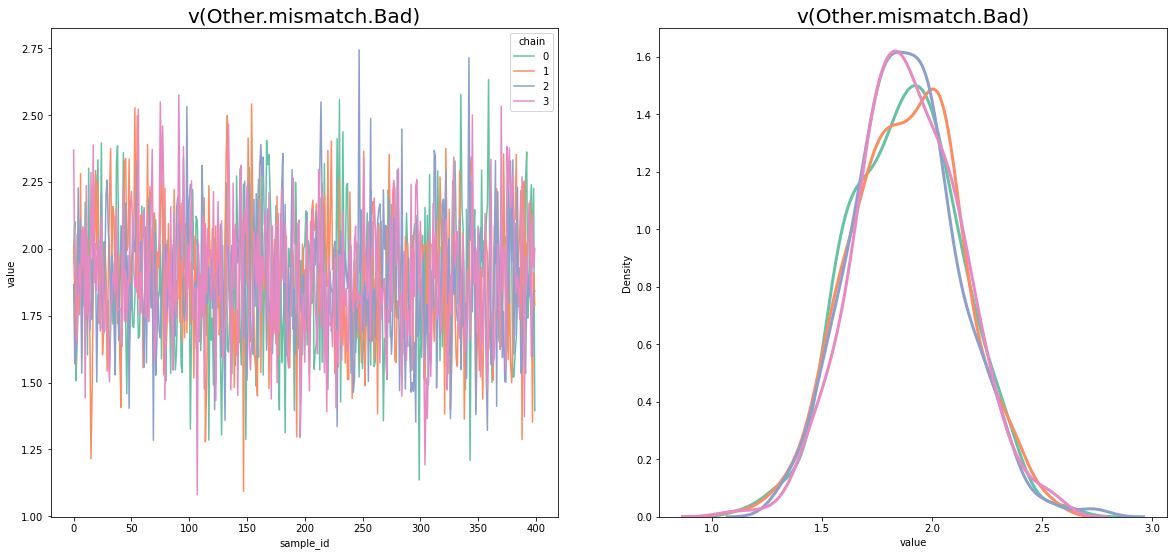

v(Other.mismatch.Good)


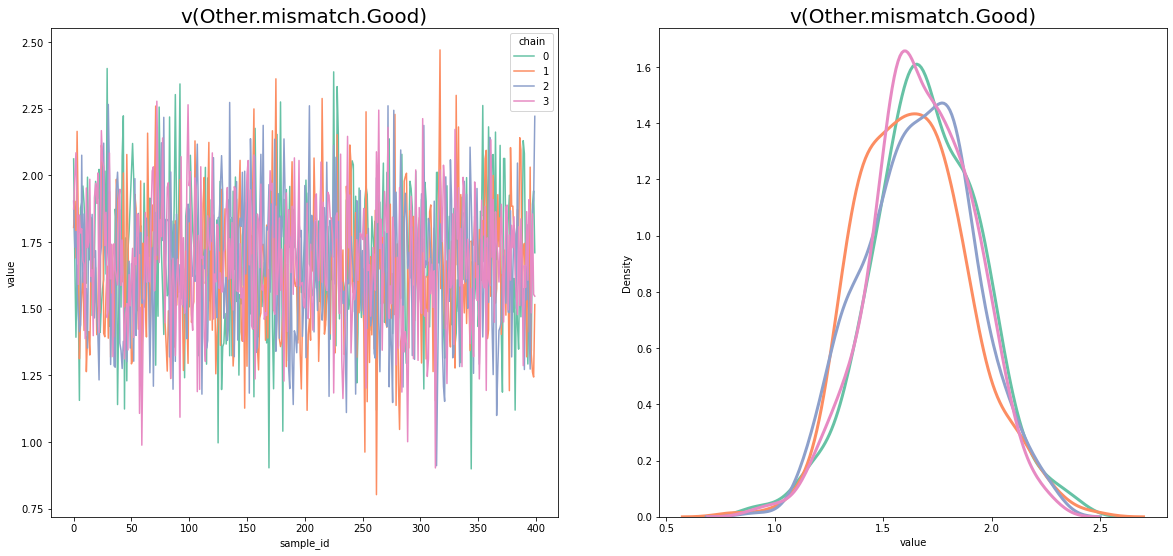

v(Self.match.Bad)


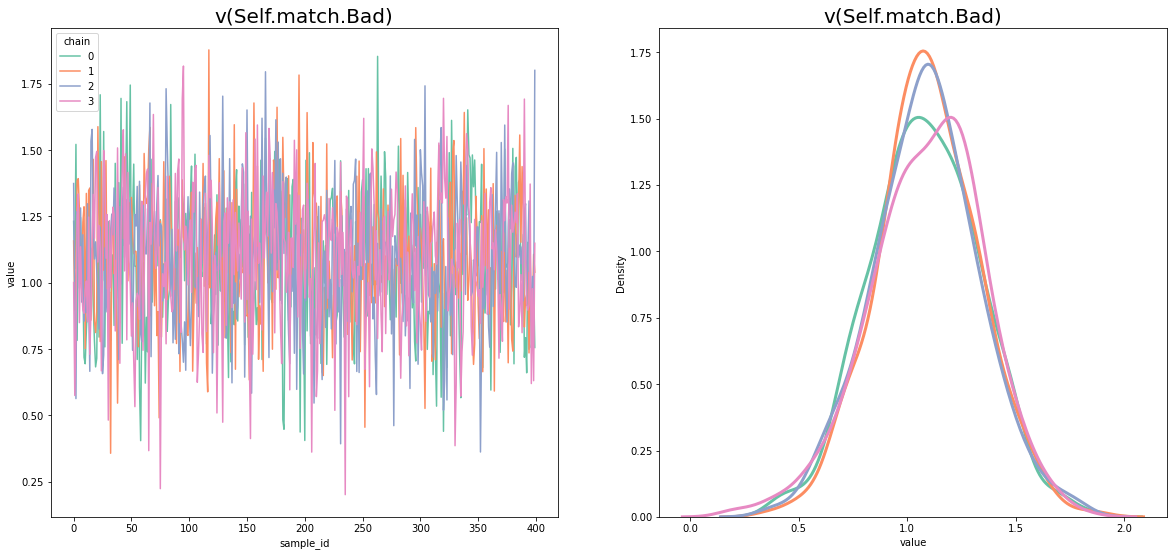

v(Self.match.Good)


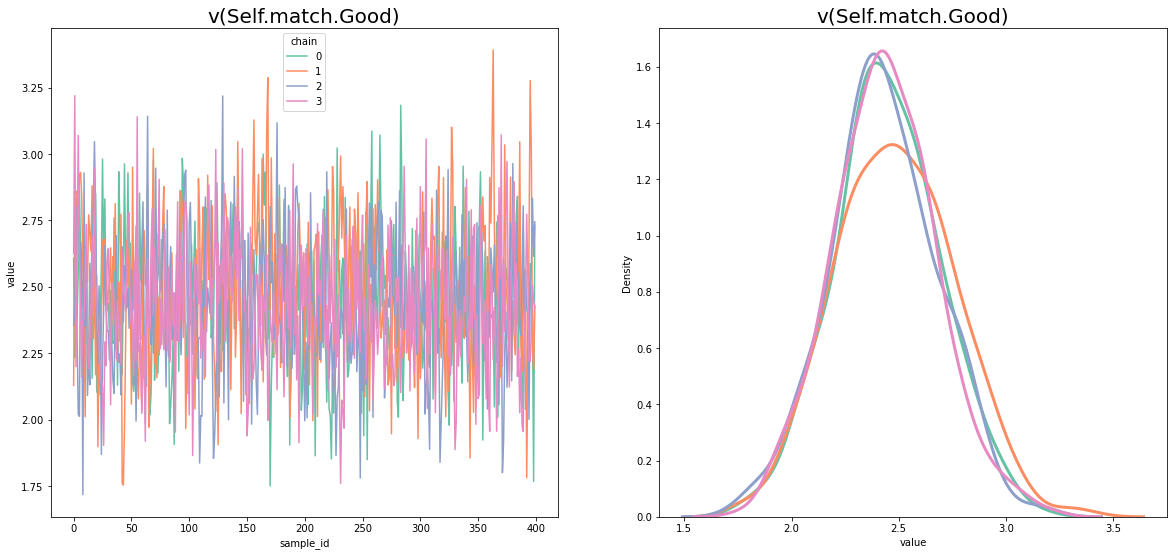

v(Self.mismatch.Bad)


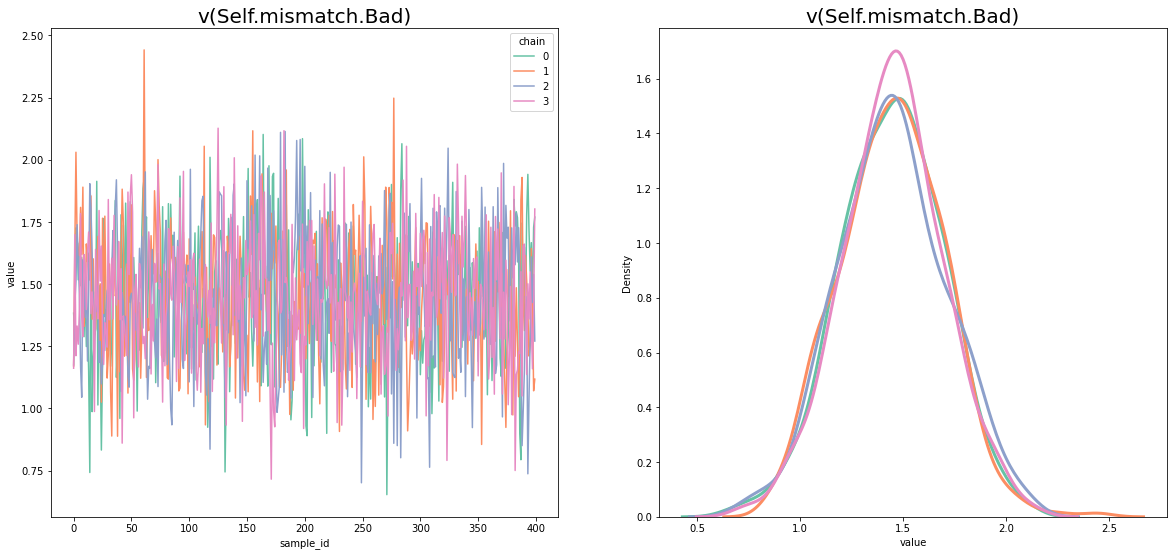

v(Self.mismatch.Good)


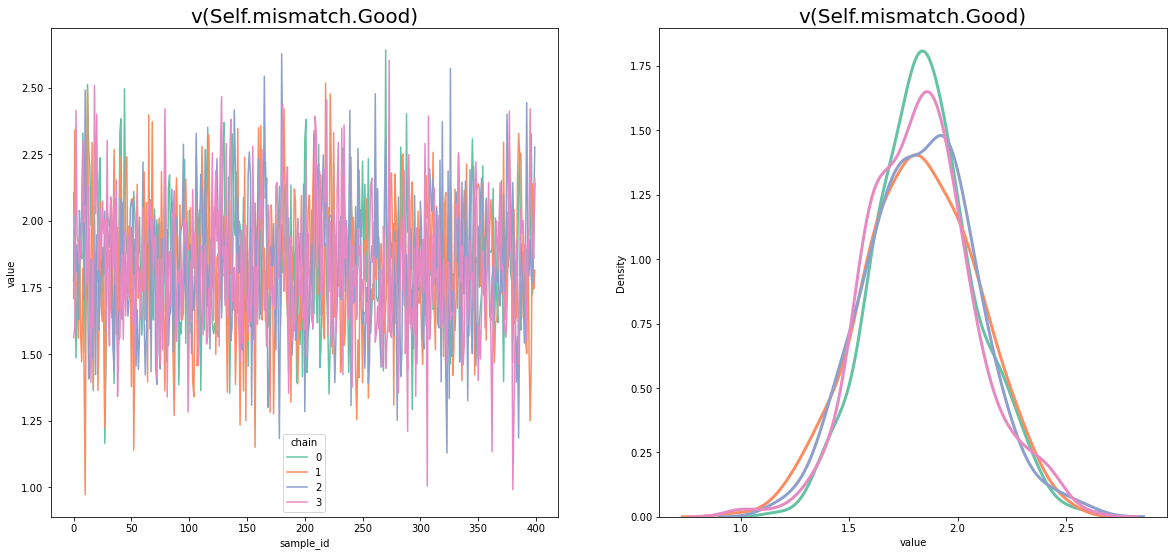

v_std


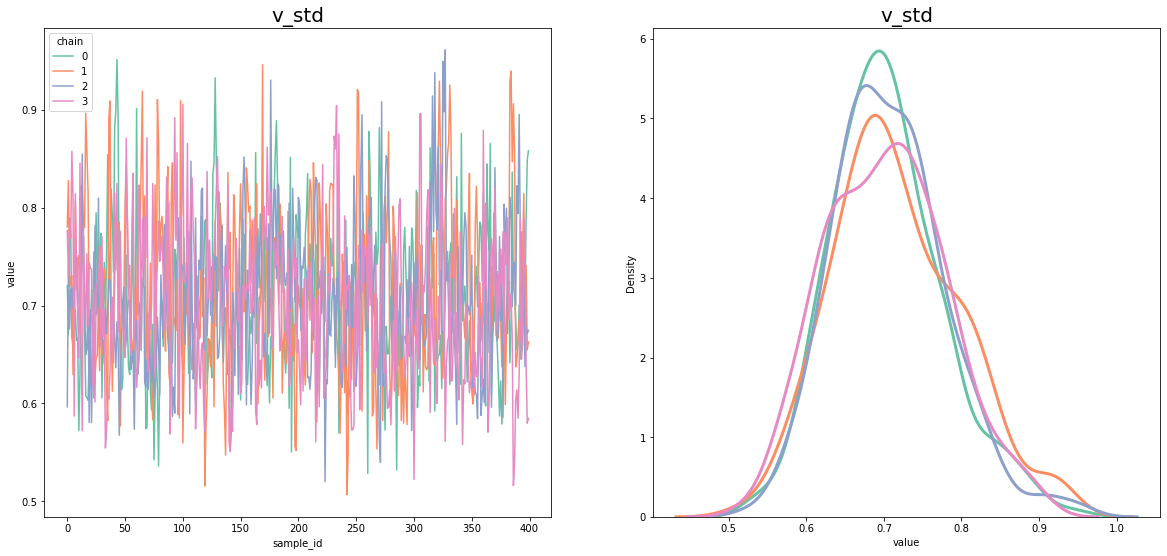

In [17]:
plot_grp_trace(models=models, param='v')

### Multiple chains with progress bar

Sometimes you want to know the progress of the multiple chains. To print out the progress, you need to define another function (See this [post](https://groups.google.com/g/hddm-users/c/lsmRwwB_9wY/m/0h8HLghcAwAJ) in hddm discussion group).

In [18]:
import sys
import time
from IPython.display import clear_output

def wait_watching_stdout(ar, dt=30):
    """
    ar: vmap output of the models being run 
    dt: number of seconds between checking output, you can make is shorter or longer.
    """

    while not ar.ready():
        stdouts = ar.stdout
        if not any(stdouts):
            continue
        # clear_output doesn't do much in terminal environments
        clear_output()
        print('-' * 30)
        print("%.3fs elapsed" % ar.elapsed)
        print("")
        for out in ar.stdout: print(out);
        sys.stdout.flush()
        time.sleep(dt)

In [19]:
from ipyparallel import Client
start_time = time.time()  # the start time of the processing
v = Client()[:]
jobs = v.map(run_model, range(4)) # 4 is the number of CPUs
wait_watching_stdout(jobs)
models = jobs.get()

m1_time = time.time() 
print("\nRunning 4 chains used: %f seconds." % (m1_time - start_time))

------------------------------
210.517s elapsed

running model0
running models 0 for for exp example
 [-----------------100%-----------------] 501 of 500 complete in 184.1 sec
running model1
running models 1 for for exp example
 [-----------------99%----------------- ] 497 of 500 complete in 184.9 sec
running model2
running models 2 for for exp example
 [-----------------99%----------------- ] 497 of 500 complete in 184.1 sec
running model3
running models 3 for for exp example
 [-----------------98%----------------- ] 491 of 500 complete in 183.5 sec



Running 4 chains used: 240.568314 seconds.
